In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
)
from sklearn import set_config

In [2]:
set_config(transform_output="pandas")

In [3]:
df = pd.read_csv("./data/customer_churn_processed_data.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   country          10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  int64  
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### Split the data

In [5]:
X = df.drop("exited", axis=1)
y = df["exited"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [6]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep="\n")

(8000, 10)
(8000,)
(2000, 10)
(2000,)


In [7]:
y_train.value_counts(normalize=True)

exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64

In [8]:
y_test.value_counts(normalize=True)

exited
0    0.7965
1    0.2035
Name: proportion, dtype: float64

### Define categorical transformer

In [9]:
category_transformer = ColumnTransformer(
    [
        (
            "cat_encoder",
            OneHotEncoder(sparse_output=False, drop="if_binary"),
            ["country", "gender"],
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

### Define utility functions and tables

In [10]:
def get_errors(estimator, X, y):
    preds = estimator.predict(X)
    accuracy = accuracy_score(y, preds)
    recall = recall_score(y, preds)
    precision = precision_score(y, preds, zero_division=0.0)
    return {"accuracy": accuracy, "recall": recall, "precision": precision}


def get_avg_cv_errors(cv_result):
    return {
        "accuracy": cv_result["test_accuracy"].mean(),
        "recall": cv_result["test_recall"].mean(),
        "precision": cv_result["test_precision"].mean(),
    }

def plot_confusion_matrix(estimator, X_train, X_test, y_train, y_test):
    ConfusionMatrixDisplay.from_estimator(estimator, X_train, y_train)
    plt.title("Confusion Matrix of Baseline Model [Training Set]");

    ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)
    plt.title("Confusion Matrix of Baseline Model [Test Set]");

In [11]:
perf_df = pd.DataFrame(
    columns=[
        "train_accuracy",
        "train_recall",
        "train_precision",
        "cv_accuracy",
        "cv_recall",
        "cv_precision",
        "test_accuracy",
        "test_recall",
        "test_precision"
    ]
)

In [12]:
def log_error(model_name, errors, eval_set):
    cols = [eval_set + "_" + err for err in ("accuracy", "recall", "precision")]
    perf_df.loc[model_name, cols] = list(errors)

### Build and Evaluate Baseline Model

In [13]:
base_model = DummyClassifier()  # Instantiate the model
base_model.fit(X_train, y_train)  # Train the model

,strategy,'prior'
,random_state,None
,constant,None


In [14]:
train_pred = base_model.predict(X_train)  # Generate train prediction

In [15]:
train_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
# Evaluate training predictions

base_train_errors = get_errors(base_model, X_train, y_train)
base_train_errors

{'accuracy': 0.79625, 'recall': 0.0, 'precision': 0.0}

In [17]:
# Log train error
log_error("Base Model", base_train_errors.values(), "train")

In [18]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Get cross validation error

In [19]:
cv_results = cross_validate(base_model, X_train, y_train, cv=5, scoring=get_errors)

In [20]:
cv_results

{'fit_time': array([0.00382853, 0.00316167, 0.00362015, 0.00296521, 0.00169826]),
 'score_time': array([0.0118804 , 0.02289128, 0.02139211, 0.01392365, 0.00956988]),
 'test_accuracy': array([0.79625, 0.79625, 0.79625, 0.79625, 0.79625]),
 'test_recall': array([0., 0., 0., 0., 0.]),
 'test_precision': array([0., 0., 0., 0., 0.])}

In [21]:
base_avg_cv_errors = get_avg_cv_errors(cv_results)
base_avg_cv_errors

{'accuracy': np.float64(0.79625),
 'recall': np.float64(0.0),
 'precision': np.float64(0.0)}

In [22]:
log_error("Base Model", base_avg_cv_errors.values(), "cv")

In [23]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,NaN,NaN,NaN


#### Evaluate model on test set

In [24]:
test_pred = base_model.predict(X_test)

In [25]:
base_test_errors = get_errors(base_model, X_test, y_test)
base_test_errors

{'accuracy': 0.7965, 'recall': 0.0, 'precision': 0.0}

#### Save base model error

In [26]:
log_error("Base Model", base_test_errors.values(), "test")

In [27]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,0.7965,0.0,0.0


#### Plot confusion matrix

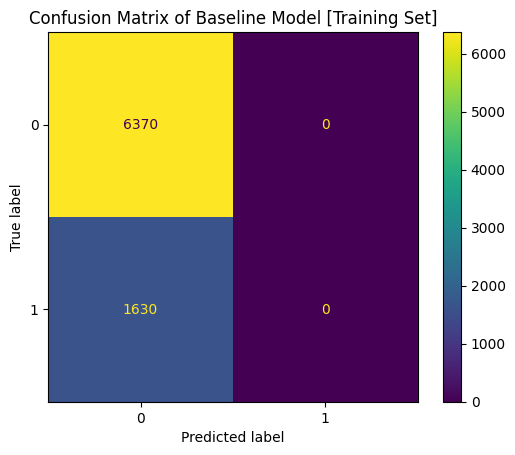

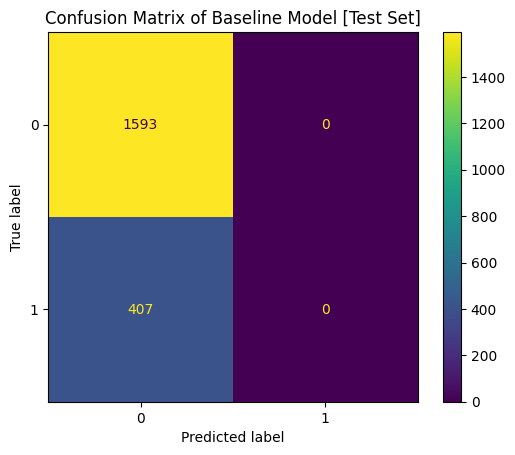

In [28]:
plot_confusion_matrix(base_model, X_train, X_test, y_train, y_test)

### Build and Evaluate Logistic Regression Model

In [27]:
lr_model = LogisticRegression(max_iter=10000)

In [28]:
pipeline = make_pipeline(category_transformer, lr_model)

In [29]:
pipeline

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


Train the model

In [30]:
pipeline.fit(X_train, y_train)

c:\Users\HP Elitebook\miniconda3\envs\churn_project\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


Evaluate the model

In [31]:
train_preds = pipeline.predict(X_train)

In [32]:
lr_train_errors = get_errors(pipeline, X_train, y_train)
lr_train_errors

{'accuracy': 0.81025,
 'recall': 0.20920245398773007,
 'precision': 0.5982456140350877}

Get cross validation result

In [33]:
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=get_errors)

c:\Users\HP Elitebook\miniconda3\envs\churn_project\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
lr_avg_cv_errors = get_avg_cv_errors(cv_results)
lr_avg_cv_errors

{'accuracy': np.float64(0.8105),
 'recall': np.float64(0.21533742331288344),
 'precision': np.float64(0.5974375748592466)}

Evaluate the model on the test set

In [35]:
lr_test_errors = get_errors(pipeline, X_test, y_test)
lr_test_errors

{'accuracy': 0.8085,
 'recall': 0.18181818181818182,
 'precision': 0.5967741935483871}

#### Log errors

In [36]:
log_error("LR Model", lr_train_errors.values(), "train")
log_error("LR Model", lr_avg_cv_errors.values(), "cv")
log_error("LR Model", lr_test_errors.values(), "test")

In [38]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,0.7965,0.0,0.0
LR Model,0.81025,0.209202,0.598246,0.8105,0.215337,0.597438,0.8085,0.181818,0.596774


### Build and Evaluate Decision Tree Model

#### Build the model

In [39]:
# Instantiate the model

dt_model = DecisionTreeClassifier(random_state=42)

In [40]:
# Create pipeline

pipeline = make_pipeline(category_transformer, dt_model)
pipeline.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


#### Evaluate the training set

In [41]:
dt_train_error = get_errors(pipeline, X_train, y_train)
dt_train_error

{'accuracy': 1.0, 'recall': 1.0, 'precision': 1.0}

#### Evaluate with cross validation

In [42]:
cv_results = cross_validate(
    pipeline, X_train, y_train, scoring=["accuracy", "precision", "recall"], cv=5
)
cv_results

{'fit_time': array([0.13497925, 0.11643839, 0.11130071, 0.11422086, 0.11265707]),
 'score_time': array([0.03013754, 0.02938271, 0.02771831, 0.03464675, 0.03064704]),
 'test_accuracy': array([0.790625, 0.789375, 0.78625 , 0.785   , 0.7925  ]),
 'test_precision': array([0.48753463, 0.48348348, 0.47619048, 0.47428571, 0.49117647]),
 'test_recall': array([0.5398773 , 0.49386503, 0.49079755, 0.50920245, 0.51226994])}

In [43]:
dt_avg_cv_error = get_avg_cv_errors(cv_results)
dt_avg_cv_error

{'accuracy': np.float64(0.7887500000000001),
 'recall': np.float64(0.50920245398773),
 'precision': np.float64(0.4825341541173381)}

#### Evaluate on test

In [44]:
dt_test_error = get_errors(pipeline, X_test, y_test)
dt_test_error

{'accuracy': 0.786,
 'recall': 0.5110565110565111,
 'precision': 0.4759725400457666}

#### Handle the overfitting issue in the decision tree

In [45]:
# Check the tree's depth

pipeline[-1].get_depth()

24

#### Find the optimal tree depth with grid search cv

In [46]:
pipeline.steps

[('columntransformer',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('cat_encoder',
                                   OneHotEncoder(drop='if_binary',
                                                 sparse_output=False),
                                   ['country', 'gender'])],
                    verbose_feature_names_out=False)),
 ('decisiontreeclassifier', DecisionTreeClassifier(random_state=42))]

In [47]:
param_grid = {"decisiontreeclassifier__max_depth": range(2, 24)}

grid_search_cv = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring=["accuracy", "recall", "precision"], refit="recall",
                             return_train_score=True)
grid_search_cv.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'decisiontreeclassifier__max_depth': range(2, 24)}"
,scoring,"['accuracy', 'recall', ...]"
,n_jobs,None
,refit,'recall'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('cat_encoder', ...)]"


In [48]:
cv_results = pd.DataFrame(grid_search_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__max_depth,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision
0,0.061000,0.010484,0.044660,0.007236,2,{'decisiontreeclassifier__max_depth': 2},0.824375,0.841875,0.821250,0.827500,...,0.626467,0.045625,8,0.615385,0.681404,0.615957,0.611828,0.603854,0.625686,0.028192
1,0.101501,0.088976,0.054678,0.029442,3,{'decisiontreeclassifier__max_depth': 3},0.843750,0.846250,0.833125,0.836875,...,0.790784,0.059099,1,0.844498,0.693548,0.862233,0.804554,0.865285,0.814024,0.064007
2,0.084611,0.029120,0.053546,0.012930,4,{'decisiontreeclassifier__max_depth': 4},0.848125,0.853750,0.839375,0.838750,...,0.768770,0.040963,4,0.808696,0.794408,0.813559,0.780186,0.737430,0.786856,0.027329
3,0.066027,0.002715,0.031799,0.006051,5,{'decisiontreeclassifier__max_depth': 5},0.848125,0.856875,0.842500,0.840625,...,0.782458,0.057202,3,0.887295,0.810726,0.781818,0.788352,0.780664,0.809771,0.040245
4,0.071727,0.005344,0.030201,0.004414,6,{'decisiontreeclassifier__max_depth': 6},0.852500,0.870000,0.843750,0.841875,...,0.782881,0.041155,2,0.839063,0.830133,0.840841,0.830460,0.780178,0.824135,0.022406


In [49]:
cv_cols = [
    "param_decisiontreeclassifier__max_depth",
    "mean_test_recall",
    "std_test_recall",
    "mean_train_recall",
    "std_train_recall",
    "rank_test_recall",
    "mean_test_accuracy",
    "mean_train_accuracy",
    "mean_test_precision",
    "mean_train_precision",
]

In [50]:
cv_results_subset = cv_results[cv_cols].sort_values(["rank_test_recall", "std_test_recall"])
cv_results_subset

,param_decisiontreeclassifier__max_depth,mean_test_recall,std_test_recall,mean_train_recall,std_train_recall,rank_test_recall,mean_test_accuracy,mean_train_accuracy,mean_test_precision,mean_train_precision
21,23,0.503681,0.018137,0.998926,0.000376,1,0.790125,0.999719,0.485455,0.999693
18,20,0.501227,0.022340,0.991871,0.003551,2,0.788250,0.998094,0.481158,0.998766
20,22,0.500613,0.026487,0.997853,0.001319,3,0.787375,0.999531,0.478924,0.999847
15,17,0.499387,0.020476,0.957975,0.008122,4,0.799000,0.990000,0.506853,0.992722
16,18,0.496933,0.016913,0.974693,0.004777,5,0.793000,0.993750,0.491994,0.994528
17,19,0.496319,0.022239,0.986350,0.003922,6,0.788875,0.996438,0.482434,0.996128
19,21,0.495092,0.020495,0.996166,0.002000,7,0.788500,0.999000,0.481427,0.998926
14,16,0.493252,0.021551,0.936810,0.007171,8,0.798750,0.985031,0.506286,0.989189
12,14,0.484049,0.014952,0.860890,0.012513,9,0.808375,0.966938,0.533508,0.973839
11,13,0.481595,0.029101,0.814877,0.011906,10,0.811500,0.954344,0.543872,0.954379


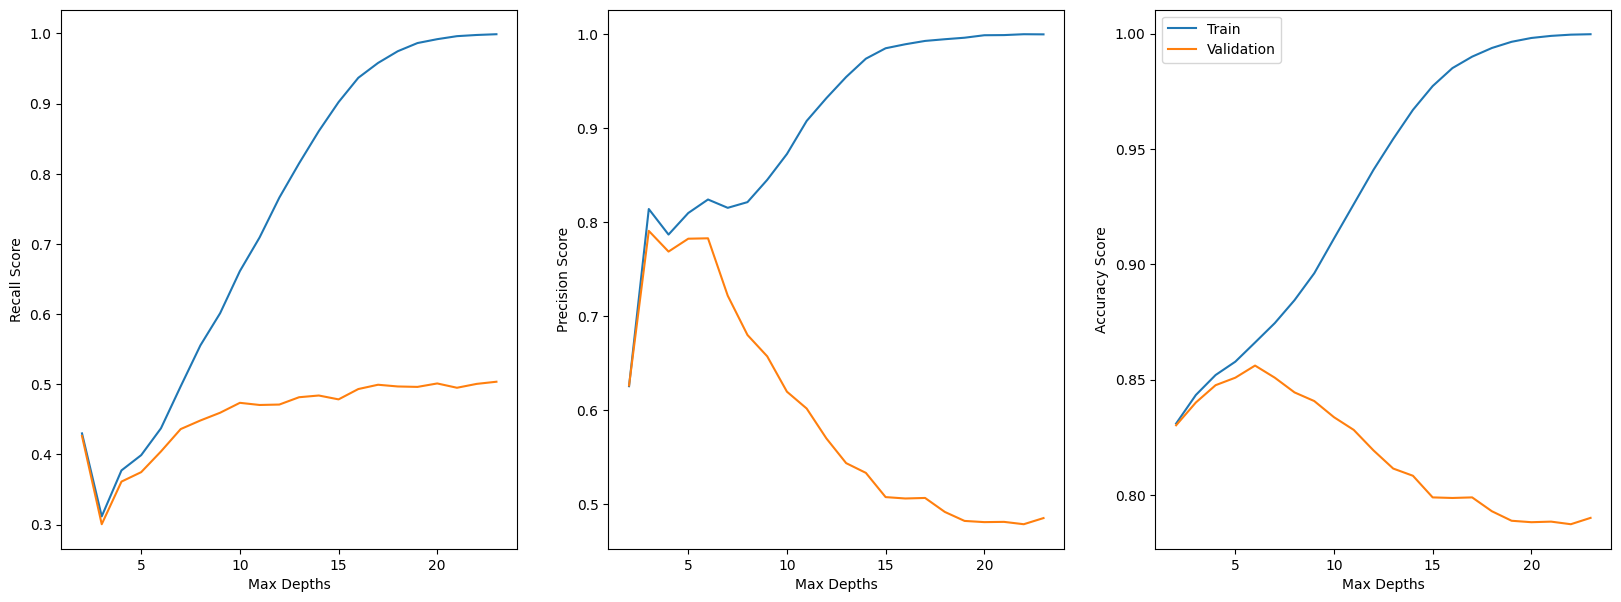

In [51]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

ax1.plot(cv_results["param_decisiontreeclassifier__max_depth"], cv_results["mean_train_recall"], label="Train")
ax1.plot(cv_results["param_decisiontreeclassifier__max_depth"], cv_results["mean_test_recall"], label="Validation")
ax1.set_xlabel("Max Depths")
ax1.set_ylabel("Recall Score")

ax2.plot(cv_results["param_decisiontreeclassifier__max_depth"], cv_results["mean_train_precision"], label="Train")
ax2.plot(cv_results["param_decisiontreeclassifier__max_depth"], cv_results["mean_test_precision"], label="Validation")
ax2.set_xlabel("Max Depths")
ax2.set_ylabel("Precision Score")

ax3.plot(cv_results["param_decisiontreeclassifier__max_depth"], cv_results["mean_train_accuracy"], label="Train")
ax3.plot(cv_results["param_decisiontreeclassifier__max_depth"], cv_results["mean_test_accuracy"], label="Validation")
ax3.set_xlabel("Max Depths")
ax3.set_ylabel("Accuracy Score")
plt.legend();

In [52]:
cv_results_subset.set_index("param_decisiontreeclassifier__max_depth").loc[[5, 6, 7, 8]]

,mean_test_recall,std_test_recall,mean_train_recall,std_train_recall,rank_test_recall,mean_test_accuracy,mean_train_accuracy,mean_test_precision,mean_train_precision
param_decisiontreeclassifier__max_depth,,,,,,,,,
5,0.374847,0.035317,0.399080,0.035626,20,0.850875,0.857812,0.782458,0.809771
6,0.404294,0.052288,0.437270,0.019560,19,0.856125,0.866125,0.782881,0.824135
7,0.436196,0.028736,0.497086,0.009909,17,0.850875,0.874531,0.721900,0.815286
8,0.448466,0.048710,0.555521,0.027077,16,0.844500,0.884469,0.680113,0.821352


We choose the best max depth as 6 because it is optimal for both accuracy and precision at that point. If we choose the max depth for the best average recall on the validation set, we would the be overfitting the other metrics.

#### Retrain the model with max_depth of 6

In [53]:
# Instantiate the model

dt_model = DecisionTreeClassifier(max_depth=6, random_state=42)

In [54]:
# Create pipeline

pipeline = make_pipeline(category_transformer, dt_model)
pipeline.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


#### Evaluate the training set

In [55]:
dt6_train_errors = get_errors(pipeline, X_train, y_train)
dt6_train_errors

{'accuracy': 0.868125,
 'recall': 0.45950920245398774,
 'precision': 0.8114842903575298}

#### Cross validate

In [56]:
cv_results = cross_validate(pipeline, X_train, y_train, cv=5, scoring=["accuracy", "recall", "precision"], n_jobs=-1)
dt6_avg_cv_errors = get_avg_cv_errors(cv_results)
dt6_avg_cv_errors

{'accuracy': np.float64(0.8561250000000001),
 'recall': np.float64(0.40429447852760736),
 'precision': np.float64(0.7828812283541768)}

#### Evaluate on test

In [57]:
dt6_test_errors = get_errors(pipeline, X_test, y_test)
dt6_test_errors

{'accuracy': 0.8595,
 'recall': 0.44226044226044225,
 'precision': 0.7692307692307693}

#### Log errors

In [58]:
log_error("DT Model", dt6_train_errors.values(), "train")
log_error("DT Model", dt6_avg_cv_errors.values(), "cv")
log_error("DT Model", dt6_test_errors.values(), "test")

In [59]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,0.7965,0.0,0.0
LR Model,0.81025,0.209202,0.598246,0.8105,0.215337,0.597438,0.8085,0.181818,0.596774
DT Model,0.868125,0.459509,0.811484,0.856125,0.404294,0.782881,0.8595,0.44226,0.769231


### Random Forest

#### Build the model

In [60]:
# Instantiate the model

rf_model = RandomForestClassifier(max_depth=6, random_state=42)

In [62]:
# Create pipeline

pipeline = make_pipeline(category_transformer, rf_model)
pipeline.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


#### Evaluate the training set

In [63]:
rf_train_errors = get_errors(pipeline, X_train, y_train)
rf_train_errors

{'accuracy': 0.867,
 'recall': 0.3993865030674847,
 'precision': 0.8845108695652174}

#### Evaluate with cross validation

In [64]:
cv_results = cross_validate(pipeline, X_train, y_train, scoring=["accuracy", "precision", "recall"], cv=5)
rf_avg_cv_errors = get_avg_cv_errors(cv_results)
rf_avg_cv_errors

{'accuracy': np.float64(0.8578749999999999),
 'recall': np.float64(0.38343558282208584),
 'precision': np.float64(0.8268908821453659)}

#### Evaluate on test

In [65]:
rf_test_errors = get_errors(pipeline, X_test, y_test)
rf_test_errors

{'accuracy': 0.8605,
 'recall': 0.37346437346437344,
 'precision': 0.8636363636363636}

#### Log errors

In [66]:
log_error("RF Model", rf_train_errors.values(), "train")
log_error("RF Model", rf_avg_cv_errors.values(), "cv")
log_error("RF Model", rf_test_errors.values(), "test")

In [67]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,0.7965,0.0,0.0
LR Model,0.81025,0.209202,0.598246,0.8105,0.215337,0.597438,0.8085,0.181818,0.596774
DT Model,0.868125,0.459509,0.811484,0.856125,0.404294,0.782881,0.8595,0.44226,0.769231
RF Model,0.867,0.399387,0.884511,0.857875,0.383436,0.826891,0.8605,0.373464,0.863636


### Gradient Boosting

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

#### Build the model

In [69]:
# Instantiate the model

gb_model = GradientBoostingClassifier(max_depth=6, random_state=42)

In [70]:
# Create pipeline

pipeline = make_pipeline(category_transformer, gb_model)
pipeline.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('gradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


#### Evaluate the training set

In [71]:
gb_train_errors = get_errors(pipeline, X_train, y_train)
gb_train_errors

{'accuracy': 0.923625,
 'recall': 0.6723926380368098,
 'precision': 0.9343563512361467}

#### Evaluate with cross validation

In [72]:
cv_results = cross_validate(pipeline, X_train, y_train, scoring=["accuracy", "precision", "recall"], cv=5)
gb_avg_cv_errors = get_avg_cv_errors(cv_results)
gb_avg_cv_errors

{'accuracy': np.float64(0.859875),
 'recall': np.float64(0.47975460122699387),
 'precision': np.float64(0.7420636051761955)}

#### Evaluate on test

In [73]:
gb_test_errors = get_errors(pipeline, X_test, y_test)
gb_test_errors

{'accuracy': 0.8625, 'recall': 0.47665847665847666, 'precision': 0.7578125}

#### Log errors

In [74]:
log_error("GB Model", gb_train_errors.values(), "train")
log_error("GB Model", gb_avg_cv_errors.values(), "cv")
log_error("GB Model", gb_test_errors.values(), "test")

In [74]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,0.7965,0.0,0.0
LR Model,0.810625,0.213497,0.598967,0.810375,0.21411,0.597122,0.809,0.189189,0.596899
DT Model,0.868125,0.459509,0.811484,0.856125,0.404294,0.782881,0.8595,0.44226,0.769231
RF Model,0.867,0.399387,0.884511,0.857875,0.383436,0.826891,0.8605,0.373464,0.863636
GB Model,0.923625,0.672393,0.934356,0.86,0.479755,0.742732,0.8625,0.476658,0.757812


#### Add kmeans labels as features to GB model

In [75]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [158]:
class CustomKMeans(KMeans):
    def get_feature_names_out(self):
        feats = np.concatenate((self.feature_names_in_, ["cluster_label"]))
        return feats
    def _transform(self, X):
        labels = self.predict(X).reshape(-1, 1)
        X_t = np.hstack((X, labels))
        return X_t
    
    def transform(self, X):
        return self._transform(X)

In [161]:
ckmeans = CustomKMeans(14, random_state=42)

In [101]:
kmeans_pipe = make_pipeline(
    category_transformer,
    ColumnTransformer(
        [
            (
                "scaler",
                StandardScaler(),
                [
                    "creditscore",
                    "age",
                    "tenure",
                    "balance",
                    "numofproducts",
                    "estimatedsalary",
                ],
            )
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    ckmeans
)

In [105]:
gb_kmeans_pipeline = make_pipeline(
    kmeans_pipe,
    ColumnTransformer(
        [("cat_encoder", OneHotEncoder(sparse_output=False), ["cluster_label"])],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    gb_model
)

In [106]:
gb_kmeans_pipeline.fit(X_train, y_train)

,steps,"[('pipeline', ...), ('columntransformer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('columntransformer-1', ...), ('columntransformer-2', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3


#### Evaluate the training set

In [107]:
gb_train_errors = get_errors(gb_kmeans_pipeline, X_train, y_train)
gb_train_errors

{'accuracy': 0.922,
 'recall': 0.6680981595092025,
 'precision': 0.9291808873720137}

#### Evaluate with cross validation

In [108]:
cv_results = cross_validate(gb_kmeans_pipeline, X_train, y_train, scoring=["accuracy", "precision", "recall"], cv=5)
gb_avg_cv_errors = get_avg_cv_errors(cv_results)
gb_avg_cv_errors

{'accuracy': np.float64(0.8594999999999999),
 'recall': np.float64(0.48588957055214727),
 'precision': np.float64(0.7368074057458037)}

#### Evaluate on test

In [109]:
gb_test_errors = get_errors(gb_kmeans_pipeline, X_test, y_test)
gb_test_errors

{'accuracy': 0.8625, 'recall': 0.4864864864864865, 'precision': 0.75}

#### Log errors

In [110]:
log_error("GB_KM Model", gb_train_errors.values(), "train")
log_error("GB_KM Model", gb_avg_cv_errors.values(), "cv")
log_error("GB_KM Model", gb_test_errors.values(), "test")

In [111]:
perf_df

,train_accuracy,train_recall,train_precision,cv_accuracy,cv_recall,cv_precision,test_accuracy,test_recall,test_precision
Base Model,0.79625,0.0,0.0,0.79625,0.0,0.0,0.7965,0.0,0.0
LR Model,0.81025,0.209202,0.598246,0.8105,0.215337,0.597438,0.8085,0.181818,0.596774
DT Model,0.868125,0.459509,0.811484,0.856125,0.404294,0.782881,0.8595,0.44226,0.769231
RF Model,0.867,0.399387,0.884511,0.857875,0.383436,0.826891,0.8605,0.373464,0.863636
GB Model,0.923625,0.672393,0.934356,0.859875,0.479755,0.742064,0.8625,0.476658,0.757812
GB_KM Model,0.922,0.668098,0.929181,0.8595,0.48589,0.736807,0.8625,0.486486,0.75


## Choose the best model

We choose the "GB_KM" model as the best model because it has the highest recall in the cross validation and test sets respectively.

## Plot Confusion Matrix of GB_KM model

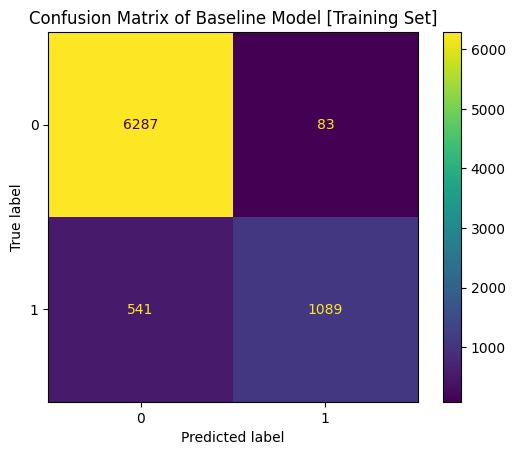

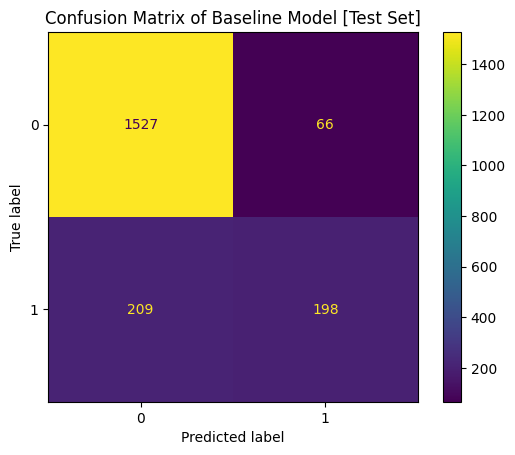

In [112]:
plot_confusion_matrix(gb_kmeans_pipeline, X_train, X_test, y_train, y_test)

## Visualize feature importance

In [113]:
feat_imps = pd.Series(
    gb_kmeans_pipeline[-1].feature_importances_,
    index=gb_kmeans_pipeline[-1].feature_names_in_,
).sort_values()

<Axes: >

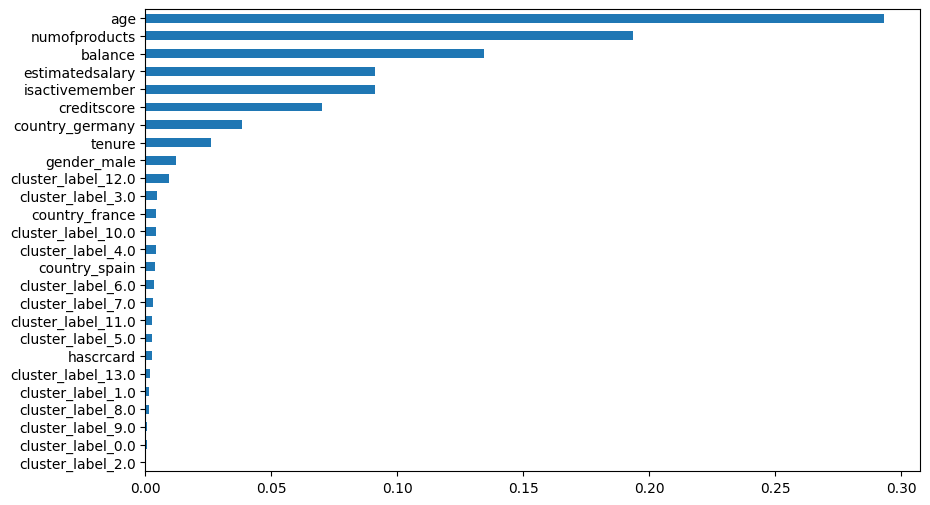

In [114]:
feat_imps.plot(kind="barh", figsize=(10, 6))

## Plot precision recall curve

In [ ]:
from sklearn.metrics import precision_recall_curve

In [120]:
precisions, recalls, _  = precision_recall_curve(
    y_test, gb_kmeans_pipeline.predict_proba(X_test)[:, 1]
)

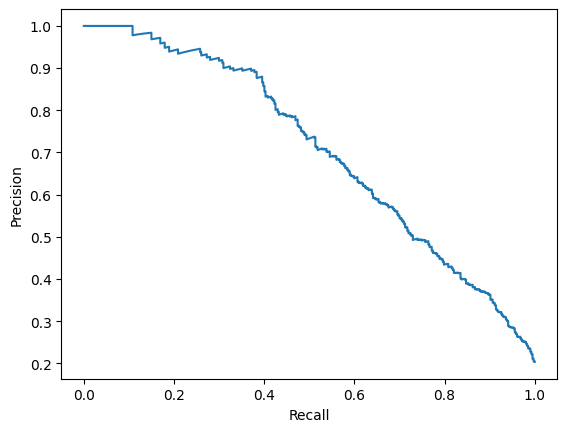

In [122]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision");

## Find optimal probability threshold

In [123]:
from sklearn.model_selection import TunedThresholdClassifierCV

In [124]:
ttcv = TunedThresholdClassifierCV(gb_kmeans_pipeline, cv=5)
ttcv.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,scoring,'balanced_accuracy'
,response_method,'auto'
,thresholds,100
,cv,5
,refit,True
,n_jobs,None
,random_state,None
,store_cv_results,False
,steps,"[('columntransformer-1', ...), ('columntransformer-2', ...), ...]"
,transform_input,None


In [125]:
get_errors(ttcv, X_train, y_train)

{'accuracy': 0.858625,
 'recall': 0.9404907975460123,
 'precision': 0.5971951694585119}

In [126]:
ttcv.best_threshold_

np.float64(0.16391024544616267)

In [127]:
get_errors(ttcv, X_test, y_test)

{'accuracy': 0.775,
 'recall': 0.7714987714987716,
 'precision': 0.46795827123695977}

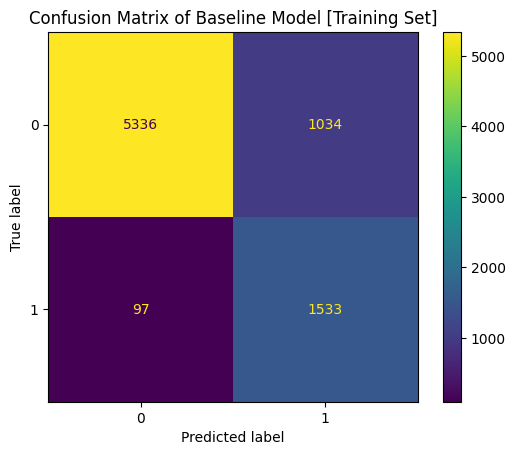

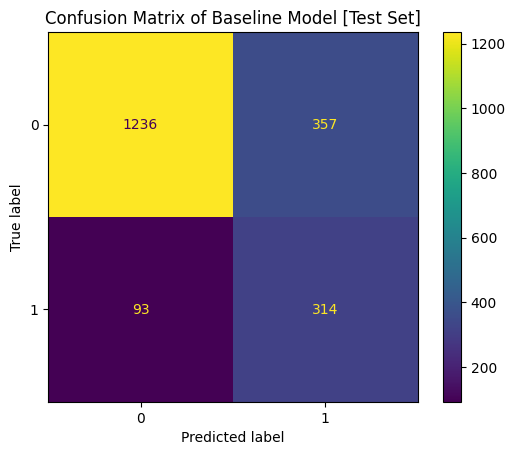

In [128]:
plot_confusion_matrix(ttcv, X_train, X_test, y_train, y_test)

## Refit the model on the whole dataset

In [131]:
from sklearn.model_selection import FixedThresholdClassifier

In [140]:
X.head()

,creditscore,country,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,619,france,female,42,2,0.00,1,1,1,101348.88
1,608,spain,female,41,1,83807.86,1,0,1,112542.58
2,502,france,female,42,8,159660.80,3,1,0,113931.57
3,699,france,female,39,1,0.00,2,0,0,93826.63
4,850,spain,female,43,2,125510.82,1,1,1,79084.10


In [141]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: exited, dtype: int64

In [134]:
ftc = FixedThresholdClassifier(gb_kmeans_pipeline, threshold=ttcv.best_threshold_)
ftc.fit(X, y)

,estimator,Pipeline(step...m_state=42))])
,threshold,np.float64(0....1024544616267)
,pos_label,None
,response_method,'auto'
,steps,"[('columntransformer-1', ...), ('columntransformer-2', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [135]:
get_errors(ftc, X, y)

{'accuracy': 0.8504,
 'recall': 0.9209621993127147,
 'precision': 0.5842416692619121}

### Save the model

In [136]:
import joblib

In [137]:
joblib.dump(ftc, "./models/churn_model.pkl")

['./models/churn_model.pkl']

## Load and test the model

In [138]:
model = joblib.load("./models/churn_model.pkl")

In [139]:
get_errors(model, X, y)

{'accuracy': 0.8504,
 'recall': 0.9209621993127147,
 'precision': 0.5842416692619121}